In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
!pip install keras==2.2.4

In [3]:
import os
import numpy as np
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-4
n_classes        = 10
train_batch_size = 32
val_batch_size   = 10
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

The scikit-learn version is 0.20.0.


Using TensorFlow backend.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [4]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [5]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

# Normalizing the data
trainVal_data = (trainVal_data / 127.5) - 1.
X_test = (X_test  / 127.5) - 1.

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


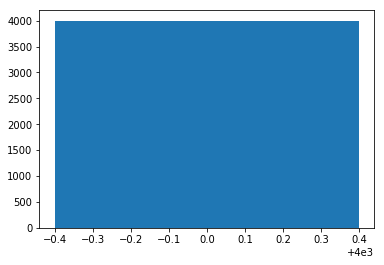

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


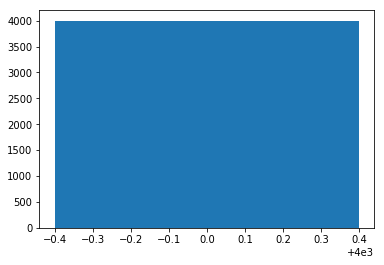

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


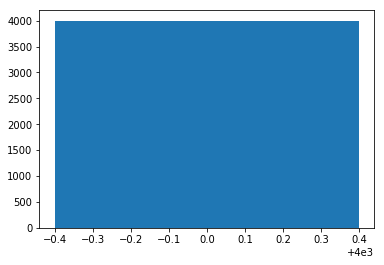

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


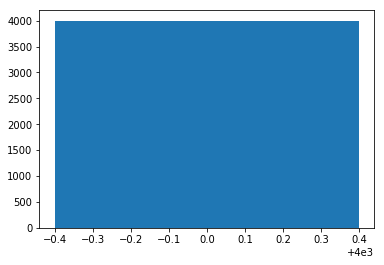

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


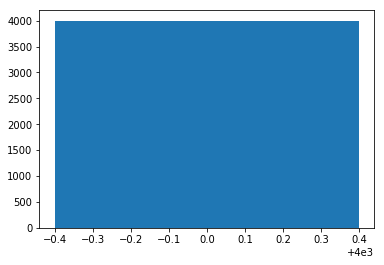

<Figure size 432x288 with 0 Axes>

In [6]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [7]:
def get_squeezenet_ft():
    #=====================================
    # Freezing layers
    #=====================================

    squeezeNetModel = SqueezeNet((32,32,3))

    #freeze layers
    for layer in squeezeNetModel.layers:
        layer.trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    #=====================================
    # Compile model
    #=====================================

    #--- Compile the model
    # It means to configure the model for training.
    # Other types of optimizer:
    #    optimizers.Adam(lr=learning_rate)
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model  = get_squeezenet_ft()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [8]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model  = get_squeezenet_ft()
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),
              verbose=1)
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 7s 165us/step - loss: 2.3011 - acc: 0.1310 - val_loss: 2.2523 - val_acc: 0.2311
Epoch 2/100
40000/40000 [==============================] - 6s 139us/step - loss: 2.2011 - acc: 0.2064 - val_loss: 2.0665 - val_acc: 0.3217
Epoch 3/100
40000/40000 [==============================] - 5s 135us/step - loss: 2.0892 - acc: 0.2584 - val_loss: 1.9691 - val_acc: 0.3593
Epoch 4/100
40000/40000 [==============================] - 6s 154us/step - loss: 2.0204 - acc: 0.2921 - val_loss: 1.9215 - val_acc: 0.3683
Epoch 5/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.9528 - acc: 0.3071 - val_loss: 1.8487 - val_acc: 0.3812
Epoch 6/100
40000/40000 [==============================] - 6s 162us/step - loss: 1.9078 - acc: 0.3230 - val_loss: 1.8170 - val_acc: 0.3918
Epoch 7/100
4

Epoch 58/100
40000/40000 [==============================] - 6s 142us/step - loss: 1.7575 - acc: 0.3709 - val_loss: 1.6510 - val_acc: 0.4252
Epoch 59/100
40000/40000 [==============================] - 6s 142us/step - loss: 1.7572 - acc: 0.3715 - val_loss: 1.6507 - val_acc: 0.4266
Epoch 60/100
40000/40000 [==============================] - 6s 146us/step - loss: 1.7591 - acc: 0.3717 - val_loss: 1.6495 - val_acc: 0.4252
Epoch 61/100
40000/40000 [==============================] - 6s 146us/step - loss: 1.7535 - acc: 0.3707 - val_loss: 1.6497 - val_acc: 0.4274
Epoch 62/100
40000/40000 [==============================] - 6s 155us/step - loss: 1.7555 - acc: 0.3703 - val_loss: 1.6487 - val_acc: 0.4265
Epoch 63/100
40000/40000 [==============================] - 6s 150us/step - loss: 1.7571 - acc: 0.3740 - val_loss: 1.6486 - val_acc: 0.4261
Epoch 64/100
40000/40000 [==============================] - 6s 160us/step - loss: 1.7571 - acc: 0.3710 - val_loss: 1.6489 - val_acc: 0.4260
Epoch 65/100
40000/4

Epoch 14/100
40000/40000 [==============================] - 6s 157us/step - loss: 1.8096 - acc: 0.3555 - val_loss: 1.7216 - val_acc: 0.4108
Epoch 15/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.8060 - acc: 0.3547 - val_loss: 1.7168 - val_acc: 0.4123
Epoch 16/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.8015 - acc: 0.3568 - val_loss: 1.7121 - val_acc: 0.4111
Epoch 17/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7968 - acc: 0.3600 - val_loss: 1.7073 - val_acc: 0.4156
Epoch 18/100
40000/40000 [==============================] - 6s 148us/step - loss: 1.7957 - acc: 0.3594 - val_loss: 1.7045 - val_acc: 0.4139
Epoch 19/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7937 - acc: 0.3630 - val_loss: 1.7011 - val_acc: 0.4145
Epoch 20/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7895 - acc: 0.3611 - val_loss: 1.6979 - val_acc: 0.4148
Epoch 21/100
40000/4

40000/40000 [==============================] - 6s 147us/step - loss: 1.7551 - acc: 0.3725 - val_loss: 1.6518 - val_acc: 0.4287
Epoch 73/100
40000/40000 [==============================] - 6s 146us/step - loss: 1.7533 - acc: 0.3731 - val_loss: 1.6518 - val_acc: 0.4263
Epoch 74/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.7562 - acc: 0.3719 - val_loss: 1.6514 - val_acc: 0.4260
Epoch 75/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.7550 - acc: 0.3727 - val_loss: 1.6511 - val_acc: 0.4264
Epoch 76/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7518 - acc: 0.3716 - val_loss: 1.6515 - val_acc: 0.4281
Epoch 77/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7509 - acc: 0.3716 - val_loss: 1.6515 - val_acc: 0.4276
Epoch 78/100
40000/40000 [==============================] - 6s 147us/step - loss: 1.7497 - acc: 0.3716 - val_loss: 1.6501 - val_acc: 0.4307
Epoch 79/100
40000/40000 [=======

Epoch 28/100
40000/40000 [==============================] - 6s 148us/step - loss: 1.7797 - acc: 0.3623 - val_loss: 1.6658 - val_acc: 0.4247
Epoch 29/100
40000/40000 [==============================] - 7s 177us/step - loss: 1.7792 - acc: 0.3651 - val_loss: 1.6641 - val_acc: 0.4254
Epoch 30/100
40000/40000 [==============================] - 7s 179us/step - loss: 1.7802 - acc: 0.3653 - val_loss: 1.6623 - val_acc: 0.4248
Epoch 31/100
40000/40000 [==============================] - 6s 157us/step - loss: 1.7769 - acc: 0.3667 - val_loss: 1.6615 - val_acc: 0.4251
Epoch 32/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.7775 - acc: 0.3634 - val_loss: 1.6601 - val_acc: 0.4242
Epoch 33/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.7715 - acc: 0.3681 - val_loss: 1.6582 - val_acc: 0.4257
Epoch 34/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.7768 - acc: 0.3652 - val_loss: 1.6574 - val_acc: 0.4252
Epoch 35/100
40000/4

40000/40000 [==============================] - 6s 153us/step - loss: 1.7550 - acc: 0.3735 - val_loss: 1.6310 - val_acc: 0.4325
Epoch 87/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.7542 - acc: 0.3715 - val_loss: 1.6311 - val_acc: 0.4345
Epoch 88/100
40000/40000 [==============================] - 6s 160us/step - loss: 1.7486 - acc: 0.3754 - val_loss: 1.6308 - val_acc: 0.4287
Epoch 89/100
40000/40000 [==============================] - 6s 149us/step - loss: 1.7520 - acc: 0.3730 - val_loss: 1.6302 - val_acc: 0.4340
Epoch 90/100
40000/40000 [==============================] - 6s 150us/step - loss: 1.7551 - acc: 0.3731 - val_loss: 1.6303 - val_acc: 0.4328
Epoch 91/100
40000/40000 [==============================] - 6s 159us/step - loss: 1.7490 - acc: 0.3721 - val_loss: 1.6305 - val_acc: 0.4301
Epoch 92/100
40000/40000 [==============================] - 6s 154us/step - loss: 1.7570 - acc: 0.3721 - val_loss: 1.6302 - val_acc: 0.4314
Epoch 93/100
40000/40000 [=======

Epoch 42/100
40000/40000 [==============================] - 6s 160us/step - loss: 1.7696 - acc: 0.3669 - val_loss: 1.6583 - val_acc: 0.4245
Epoch 43/100
40000/40000 [==============================] - 6s 158us/step - loss: 1.7637 - acc: 0.3711 - val_loss: 1.6573 - val_acc: 0.4262
Epoch 44/100
40000/40000 [==============================] - 6s 162us/step - loss: 1.7658 - acc: 0.3665 - val_loss: 1.6569 - val_acc: 0.4231
Epoch 45/100
40000/40000 [==============================] - 6s 159us/step - loss: 1.7621 - acc: 0.3682 - val_loss: 1.6560 - val_acc: 0.4231
Epoch 46/100
40000/40000 [==============================] - 6s 161us/step - loss: 1.7634 - acc: 0.3703 - val_loss: 1.6554 - val_acc: 0.4241
Epoch 47/100
40000/40000 [==============================] - 6s 158us/step - loss: 1.7671 - acc: 0.3692 - val_loss: 1.6546 - val_acc: 0.4230
Epoch 48/100
40000/40000 [==============================] - 6s 159us/step - loss: 1.7615 - acc: 0.3705 - val_loss: 1.6542 - val_acc: 0.4255
Epoch 49/100
40000/4

10000/10000 [==============================] - 3s 261us/step
Validation loss: 1.637387619972229
Validation accuracy (NORMALIZED): 0.4277000068500638
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 7s 174us/step - loss: 2.2892 - acc: 0.1413 - val_loss: 2.2367 - val_acc: 0.2323
Epoch 2/100
40000/40000 [==============================] - 6s 158us/step - loss: 2.1945 - acc: 0.2116 - val_loss: 2.0693 - val_acc: 0.3249
Epoch 3/100
40000/40000 [==============================] - 7s 164us/step - loss: 2.0901 - acc: 0.2602 - val_loss: 1.9663 - val_acc: 0.3574
Epoch 4/100
40000/40000 [==============================] - 6s 160us/step - loss: 1.9935 - acc: 0.2905 - val_loss: 1.8734 - val_acc: 0.3814
Epoch 5/100
40000/40000 [==============================] - 6s 159us/step - loss: 1.9359 - acc: 0.3132 - val_loss: 1.8310 - val_acc: 0.3880
Epo

Epoch 56/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.7624 - acc: 0.3702 - val_loss: 1.6475 - val_acc: 0.4241
Epoch 57/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.7601 - acc: 0.3695 - val_loss: 1.6466 - val_acc: 0.4235
Epoch 58/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.7577 - acc: 0.3710 - val_loss: 1.6461 - val_acc: 0.4236
Epoch 59/100
40000/40000 [==============================] - 6s 153us/step - loss: 1.7588 - acc: 0.3707 - val_loss: 1.6457 - val_acc: 0.4233
Epoch 60/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.7548 - acc: 0.3724 - val_loss: 1.6455 - val_acc: 0.4247
Epoch 61/100
40000/40000 [==============================] - 6s 152us/step - loss: 1.7627 - acc: 0.3698 - val_loss: 1.6447 - val_acc: 0.4214
Epoch 62/100
40000/40000 [==============================] - 6s 154us/step - loss: 1.7569 - acc: 0.3718 - val_loss: 1.6445 - val_acc: 0.4224
Epoch 63/100
40000/4

Finally, let's evaluate on our test set:

In [9]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.6372415020823479
Mean Validation accuracy (NORMALIZED): 0.4285800070703029


-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [10]:
def get_squeezenet_ft2():
    squeezeNetModel = SqueezeNet((32,32,3))

    #=====================================
    # Freezing mentioned layers
    #=====================================

    trainable_layer_index = 19
    for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
        squeezeNetModel.layers[i].trainable = False

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

model = get_squeezenet_ft2()
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer.name, layer.trainable)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_7[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/sque

Now, we compile our model and train it:

In [11]:
#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)

scores = []
for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft2()    
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("================================================")
    
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),              
              verbose=1)
    
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 266us/step - loss: 1.8300 - acc: 0.3448 - val_loss: 1.5034 - val_acc: 0.4692
Epoch 2/100
40000/40000 [==============================] - 10s 250us/step - loss: 1.5429 - acc: 0.4519 - val_loss: 1.4419 - val_acc: 0.4908
Epoch 3/100
40000/40000 [==============================] - 10s 238us/step - loss: 1.4797 - acc: 0.4744 - val_loss: 1.4120 - val_acc: 0.5039
Epoch 4/100
40000/40000 [==============================] - 10s 243us/step - loss: 1.4379 - acc: 0.4932 - val_loss: 1.3832 - val_acc: 0.5089
Epoch 5/100
40000/40000 [==============================] - 9s 229us/step - loss: 1.4131 - acc: 0.5014 - val_loss: 1.3697 - val_acc: 0.5144
Epoch 6/100
40000/40000 [==============================] - 9s 223us/step - loss: 1.3926 - acc: 0.5093 - val_loss: 1.3624 - val_acc: 0.5220
Epoch 7/1

Epoch 58/100
40000/40000 [==============================] - 9s 218us/step - loss: 1.0660 - acc: 0.6213 - val_loss: 1.2953 - val_acc: 0.5544
Epoch 59/100
40000/40000 [==============================] - 9s 218us/step - loss: 1.0606 - acc: 0.6221 - val_loss: 1.2846 - val_acc: 0.5546
Epoch 60/100
40000/40000 [==============================] - 9s 219us/step - loss: 1.0555 - acc: 0.6235 - val_loss: 1.2893 - val_acc: 0.5568
Epoch 61/100
40000/40000 [==============================] - 9s 216us/step - loss: 1.0519 - acc: 0.6249 - val_loss: 1.3012 - val_acc: 0.5485
Epoch 62/100
40000/40000 [==============================] - 9s 216us/step - loss: 1.0460 - acc: 0.6289 - val_loss: 1.3066 - val_acc: 0.5552
Epoch 63/100
40000/40000 [==============================] - 9s 217us/step - loss: 1.0422 - acc: 0.6288 - val_loss: 1.2943 - val_acc: 0.5541
Epoch 64/100
40000/40000 [==============================] - 9s 219us/step - loss: 1.0378 - acc: 0.6320 - val_loss: 1.2863 - val_acc: 0.5515
Epoch 65/100
40000/4

40000/40000 [==============================] - 9s 228us/step - loss: 1.3106 - acc: 0.5388 - val_loss: 1.3287 - val_acc: 0.5258
Epoch 14/100
40000/40000 [==============================] - 9s 237us/step - loss: 1.3051 - acc: 0.5387 - val_loss: 1.3162 - val_acc: 0.5308
Epoch 15/100
40000/40000 [==============================] - 9s 236us/step - loss: 1.2946 - acc: 0.5415 - val_loss: 1.3162 - val_acc: 0.5357
Epoch 16/100
40000/40000 [==============================] - 9s 230us/step - loss: 1.2884 - acc: 0.5436 - val_loss: 1.3128 - val_acc: 0.5342
Epoch 17/100
40000/40000 [==============================] - 9s 232us/step - loss: 1.2800 - acc: 0.5477 - val_loss: 1.3091 - val_acc: 0.5386
Epoch 18/100
40000/40000 [==============================] - 9s 229us/step - loss: 1.2715 - acc: 0.5509 - val_loss: 1.3062 - val_acc: 0.5388
Epoch 19/100
40000/40000 [==============================] - 9s 223us/step - loss: 1.2649 - acc: 0.5542 - val_loss: 1.3078 - val_acc: 0.5360
Epoch 20/100
40000/40000 [=======

40000/40000 [==============================] - 9s 225us/step - loss: 1.0142 - acc: 0.6383 - val_loss: 1.3273 - val_acc: 0.5496
Epoch 72/100
40000/40000 [==============================] - 9s 223us/step - loss: 1.0090 - acc: 0.6404 - val_loss: 1.3228 - val_acc: 0.5522
Epoch 73/100
40000/40000 [==============================] - 9s 226us/step - loss: 1.0082 - acc: 0.6401 - val_loss: 1.3398 - val_acc: 0.5492
Epoch 74/100
40000/40000 [==============================] - 9s 225us/step - loss: 1.0019 - acc: 0.6431 - val_loss: 1.3467 - val_acc: 0.5531
Epoch 75/100
40000/40000 [==============================] - 9s 225us/step - loss: 0.9980 - acc: 0.6453 - val_loss: 1.3457 - val_acc: 0.5485
Epoch 76/100
40000/40000 [==============================] - 9s 230us/step - loss: 0.9947 - acc: 0.6462 - val_loss: 1.3433 - val_acc: 0.5548
Epoch 77/100
40000/40000 [==============================] - 9s 225us/step - loss: 0.9885 - acc: 0.6477 - val_loss: 1.3684 - val_acc: 0.5480
Epoch 78/100
40000/40000 [=======

Epoch 27/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.2270 - acc: 0.5661 - val_loss: 1.2670 - val_acc: 0.5489
Epoch 28/100
40000/40000 [==============================] - 9s 226us/step - loss: 1.2203 - acc: 0.5684 - val_loss: 1.2748 - val_acc: 0.5465
Epoch 29/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.2140 - acc: 0.5718 - val_loss: 1.2739 - val_acc: 0.5459
Epoch 30/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.2060 - acc: 0.5753 - val_loss: 1.2687 - val_acc: 0.5494
Epoch 31/100
40000/40000 [==============================] - 9s 229us/step - loss: 1.2081 - acc: 0.5745 - val_loss: 1.2807 - val_acc: 0.5433
Epoch 32/100
40000/40000 [==============================] - 9s 231us/step - loss: 1.2009 - acc: 0.5746 - val_loss: 1.2633 - val_acc: 0.5492
Epoch 33/100
40000/40000 [==============================] - 9s 228us/step - loss: 1.1947 - acc: 0.5789 - val_loss: 1.2684 - val_acc: 0.5500
Epoch 34/100
40000/4

40000/40000 [==============================] - 9s 229us/step - loss: 0.9532 - acc: 0.6631 - val_loss: 1.3711 - val_acc: 0.5461
Epoch 86/100
40000/40000 [==============================] - 9s 234us/step - loss: 0.9471 - acc: 0.6628 - val_loss: 1.3556 - val_acc: 0.5494
Epoch 87/100
40000/40000 [==============================] - 9s 230us/step - loss: 0.9430 - acc: 0.6658 - val_loss: 1.3641 - val_acc: 0.5462
Epoch 88/100
40000/40000 [==============================] - 9s 231us/step - loss: 0.9362 - acc: 0.6667 - val_loss: 1.3677 - val_acc: 0.5455
Epoch 89/100
40000/40000 [==============================] - 9s 230us/step - loss: 0.9342 - acc: 0.6684 - val_loss: 1.3690 - val_acc: 0.5492
Epoch 90/100
40000/40000 [==============================] - 9s 229us/step - loss: 0.9262 - acc: 0.6711 - val_loss: 1.3625 - val_acc: 0.5453
Epoch 91/100
40000/40000 [==============================] - 9s 227us/step - loss: 0.9231 - acc: 0.6737 - val_loss: 1.3863 - val_acc: 0.5466
Epoch 92/100
40000/40000 [=======

40000/40000 [==============================] - 10s 243us/step - loss: 1.1532 - acc: 0.5921 - val_loss: 1.2728 - val_acc: 0.5518
Epoch 41/100
40000/40000 [==============================] - 9s 234us/step - loss: 1.1472 - acc: 0.5934 - val_loss: 1.2789 - val_acc: 0.5482
Epoch 42/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.1434 - acc: 0.5952 - val_loss: 1.2873 - val_acc: 0.5505
Epoch 43/100
40000/40000 [==============================] - 9s 227us/step - loss: 1.1402 - acc: 0.5951 - val_loss: 1.2769 - val_acc: 0.5501
Epoch 44/100
40000/40000 [==============================] - 10s 248us/step - loss: 1.1341 - acc: 0.6002 - val_loss: 1.2927 - val_acc: 0.5472
Epoch 45/100
40000/40000 [==============================] - 9s 237us/step - loss: 1.1326 - acc: 0.5962 - val_loss: 1.2746 - val_acc: 0.5503
Epoch 46/100
40000/40000 [==============================] - 9s 226us/step - loss: 1.1276 - acc: 0.5999 - val_loss: 1.2779 - val_acc: 0.5514
Epoch 47/100
40000/40000 [=====

40000/40000 [==============================] - 9s 237us/step - loss: 0.8845 - acc: 0.6857 - val_loss: 1.4147 - val_acc: 0.5402
Epoch 99/100
40000/40000 [==============================] - 9s 234us/step - loss: 0.8777 - acc: 0.6847 - val_loss: 1.4379 - val_acc: 0.5377
Epoch 100/100
10000/10000 [==============================] - 3s 308us/step
Validation loss: 1.4502276752442123
Validation accuracy (NORMALIZED): 0.5356000067591667
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 11s 284us/step - loss: 1.8566 - acc: 0.3315 - val_loss: 1.5252 - val_acc: 0.4547
Epoch 2/100
40000/40000 [==============================] - 10s 238us/step - loss: 1.5518 - acc: 0.4507 - val_loss: 1.4502 - val_acc: 0.4806
Epoch 3/100
40000/40000 [==============================] - 9s 234us/step - loss: 1.4865 - acc: 0.4748 - val_loss: 1.4182 - val_acc: 0.49

40000/40000 [==============================] - 9s 236us/step - loss: 1.0983 - acc: 0.6092 - val_loss: 1.2870 - val_acc: 0.5497
Epoch 54/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.0936 - acc: 0.6129 - val_loss: 1.3150 - val_acc: 0.5456
Epoch 55/100
40000/40000 [==============================] - 10s 240us/step - loss: 1.0881 - acc: 0.6135 - val_loss: 1.2857 - val_acc: 0.5475
Epoch 56/100
40000/40000 [==============================] - 9s 236us/step - loss: 1.0843 - acc: 0.6157 - val_loss: 1.2968 - val_acc: 0.5465
Epoch 57/100
40000/40000 [==============================] - 10s 239us/step - loss: 1.0837 - acc: 0.6124 - val_loss: 1.3037 - val_acc: 0.5469
Epoch 58/100
40000/40000 [==============================] - 10s 254us/step - loss: 1.0788 - acc: 0.6172 - val_loss: 1.3095 - val_acc: 0.5435
Epoch 59/100
40000/40000 [==============================] - 10s 256us/step - loss: 1.0725 - acc: 0.6192 - val_loss: 1.2934 - val_acc: 0.5452
Epoch 60/100
40000/40000 [==

Finally, let's evaluate on our test set:

In [12]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.440956467550993
Mean Validation accuracy (NORMALIZED): 0.5393400061115623


-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [13]:
def get_squeezenet_ft3():
    squeezeNetModel = SqueezeNet((32,32,3))

    for layer in squeezeNetModel.layers:
        layer.trainable = True       #by default they are all trainable, but just for clarification

    #=====================================
    # Add new classification layers
    #=====================================

    #--- Removing layers until drop 9
    squeezeNetModel.layers.pop() #Convolution2D
    squeezeNetModel.layers.pop() #Activation ReLU
    squeezeNetModel.layers.pop() #Global Avg Pool
    squeezeNetModel.layers.pop() #Activation Softmax

    #--- Adding classification layer for 10 classes
    out = Convolution2D(n_classes, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
    out = Activation('relu', name='relu_conv10')(out)

    out = GlobalAveragePooling2D()(out)
    out = Activation('softmax', name='loss')(out)

    #=====================================
    # New Model
    #=====================================
    model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
    opt = optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#SGD(lr=learning_rate)
    print("--- Compiling model")
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

model = get_squeezenet_ft3()
model.summary()

--- Compiling model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_________________________________________________________________________________________

Now, we compile our model and train it:

In [14]:
from time import time

#=====================================
# Tensorboard callback
#=====================================

print("--- Preparing tensorboard")
log_dir = "logs/{}".format(time())
print("Log Dir: ", log_dir)
tbCallBack = TensorBoard(log_dir=log_dir, write_graph=True)

#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_val_categorical = to_categorical(y_val, num_classes=n_classes)
scores = []

for i in range(folds):
    #--- Loading model
    model = get_squeezenet_ft3()
    
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    #print("Optimizer:", opt)
    print("================================================")
          
    #--- Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              validation_data=(X_val[i],y_val_categorical[i]),              
              verbose=1,
              callbacks=[tbCallBack])
          
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    
#--- Showing scores
print(scores)

--- Preparing tensorboard
Log Dir:  logs/1542669991.6610415
--- Start training
--- Compiling model
Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 20s 501us/step - loss: 1.4881 - acc: 0.4816 - val_loss: 1.0885 - val_acc: 0.6225
Epoch 2/100
40000/40000 [==============================] - 19s 466us/step - loss: 1.0394 - acc: 0.6466 - val_loss: 0.9641 - val_acc: 0.6703
Epoch 3/100
40000/40000 [==============================] - 19s 463us/step - loss: 0.9073 - acc: 0.6976 - val_loss: 0.8898 - val_acc: 0.6986
Epoch 4/100
40000/40000 [==============================] - 18s 461us/step - loss: 0.8210 - acc: 0.7279 - val_loss: 0.8243 - val_acc: 0.7176
Epoch 5/100
40000/40000 [==============================] - 19s 464us/step - loss: 0.7565 - acc: 0.7474 - val_loss: 0.7892 - val_acc: 0.7306
Epoch 6/100
40000/40000 [=======================

40000/40000 [==============================] - 18s 438us/step - loss: 0.0638 - acc: 0.9803 - val_loss: 1.4713 - val_acc: 0.7582
Epoch 57/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0651 - acc: 0.9800 - val_loss: 1.4867 - val_acc: 0.7589
Epoch 58/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0665 - acc: 0.9797 - val_loss: 1.4441 - val_acc: 0.7593
Epoch 59/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.0623 - acc: 0.9811 - val_loss: 1.4963 - val_acc: 0.7539
Epoch 60/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0636 - acc: 0.9806 - val_loss: 1.6365 - val_acc: 0.7447
Epoch 61/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0569 - acc: 0.9826 - val_loss: 1.5279 - val_acc: 0.7581
Epoch 62/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.0632 - acc: 0.9802 - val_loss: 1.5777 - val_acc: 0.7488
Epoch 63/100
40000/40000 [

40000/40000 [==============================] - 17s 425us/step - loss: 0.5112 - acc: 0.8330 - val_loss: 0.7512 - val_acc: 0.7553
Epoch 12/100
40000/40000 [==============================] - 17s 425us/step - loss: 0.4812 - acc: 0.8432 - val_loss: 0.7868 - val_acc: 0.7524
Epoch 13/100
40000/40000 [==============================] - 17s 425us/step - loss: 0.4504 - acc: 0.8540 - val_loss: 0.8121 - val_acc: 0.7481
Epoch 14/100
40000/40000 [==============================] - 17s 431us/step - loss: 0.4266 - acc: 0.8611 - val_loss: 0.8292 - val_acc: 0.7527
Epoch 15/100
40000/40000 [==============================] - 17s 424us/step - loss: 0.3978 - acc: 0.8702 - val_loss: 0.8471 - val_acc: 0.7471
Epoch 16/100
40000/40000 [==============================] - 17s 424us/step - loss: 0.3722 - acc: 0.8788 - val_loss: 0.9158 - val_acc: 0.7483
Epoch 17/100
40000/40000 [==============================] - 17s 426us/step - loss: 0.3502 - acc: 0.8865 - val_loss: 0.8777 - val_acc: 0.7553
Epoch 18/100
40000/40000 [

40000/40000 [==============================] - 17s 425us/step - loss: 0.0552 - acc: 0.9838 - val_loss: 1.5217 - val_acc: 0.7515
Epoch 70/100
40000/40000 [==============================] - 17s 424us/step - loss: 0.0506 - acc: 0.9844 - val_loss: 1.7048 - val_acc: 0.7505
Epoch 71/100
40000/40000 [==============================] - 17s 422us/step - loss: 0.0510 - acc: 0.9851 - val_loss: 1.6384 - val_acc: 0.7520
Epoch 72/100
40000/40000 [==============================] - 17s 424us/step - loss: 0.0530 - acc: 0.9838 - val_loss: 1.6168 - val_acc: 0.7525
Epoch 73/100
40000/40000 [==============================] - 17s 424us/step - loss: 0.0463 - acc: 0.9857 - val_loss: 1.7073 - val_acc: 0.7492
Epoch 74/100
40000/40000 [==============================] - 17s 426us/step - loss: 0.0500 - acc: 0.9851 - val_loss: 1.6719 - val_acc: 0.7442
Epoch 75/100
40000/40000 [==============================] - 17s 423us/step - loss: 0.0532 - acc: 0.9835 - val_loss: 1.6558 - val_acc: 0.7510
Epoch 76/100
40000/40000 [

40000/40000 [==============================] - 18s 438us/step - loss: 0.2416 - acc: 0.9219 - val_loss: 1.0286 - val_acc: 0.7512
Epoch 25/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.2189 - acc: 0.9312 - val_loss: 1.0234 - val_acc: 0.7497
Epoch 26/100
40000/40000 [==============================] - 17s 436us/step - loss: 0.2103 - acc: 0.9326 - val_loss: 1.0802 - val_acc: 0.7554
Epoch 27/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.1967 - acc: 0.9365 - val_loss: 1.0882 - val_acc: 0.7560
Epoch 28/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.1867 - acc: 0.9416 - val_loss: 1.0868 - val_acc: 0.7574
Epoch 29/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.1788 - acc: 0.9431 - val_loss: 1.1344 - val_acc: 0.7520
Epoch 30/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.1707 - acc: 0.9463 - val_loss: 1.1954 - val_acc: 0.7469
Epoch 31/100
40000/40000 [

40000/40000 [==============================] - 18s 440us/step - loss: 0.0459 - acc: 0.9861 - val_loss: 1.7139 - val_acc: 0.7442
Epoch 83/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.0453 - acc: 0.9860 - val_loss: 1.6442 - val_acc: 0.7556
Epoch 84/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.0450 - acc: 0.9859 - val_loss: 1.6879 - val_acc: 0.7551
Epoch 85/100
40000/40000 [==============================] - 18s 438us/step - loss: 0.0429 - acc: 0.9870 - val_loss: 1.7018 - val_acc: 0.7517
Epoch 86/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0441 - acc: 0.9866 - val_loss: 1.6351 - val_acc: 0.7509
Epoch 87/100
40000/40000 [==============================] - 18s 439us/step - loss: 0.0399 - acc: 0.9884 - val_loss: 1.7490 - val_acc: 0.7442
Epoch 88/100
40000/40000 [==============================] - 17s 437us/step - loss: 0.0443 - acc: 0.9866 - val_loss: 1.6453 - val_acc: 0.7539
Epoch 89/100
40000/40000 [

40000/40000 [==============================] - 18s 445us/step - loss: 0.1241 - acc: 0.9614 - val_loss: 1.2491 - val_acc: 0.7543
Epoch 38/100
40000/40000 [==============================] - 18s 445us/step - loss: 0.1096 - acc: 0.9670 - val_loss: 1.3186 - val_acc: 0.7516
Epoch 39/100
40000/40000 [==============================] - 18s 444us/step - loss: 0.1120 - acc: 0.9658 - val_loss: 1.3456 - val_acc: 0.7509
Epoch 40/100
40000/40000 [==============================] - 18s 443us/step - loss: 0.1042 - acc: 0.9689 - val_loss: 1.3358 - val_acc: 0.7581
Epoch 41/100
40000/40000 [==============================] - 18s 444us/step - loss: 0.1014 - acc: 0.9692 - val_loss: 1.3723 - val_acc: 0.7526
Epoch 42/100
40000/40000 [==============================] - 18s 445us/step - loss: 0.1040 - acc: 0.9681 - val_loss: 1.3997 - val_acc: 0.7477
Epoch 43/100
40000/40000 [==============================] - 18s 444us/step - loss: 0.0919 - acc: 0.9721 - val_loss: 1.3783 - val_acc: 0.7551
Epoch 44/100
40000/40000 [

40000/40000 [==============================] - 18s 444us/step - loss: 0.0407 - acc: 0.9872 - val_loss: 1.7216 - val_acc: 0.7560
Epoch 96/100
40000/40000 [==============================] - 18s 443us/step - loss: 0.0366 - acc: 0.9889 - val_loss: 1.7319 - val_acc: 0.7545
Epoch 97/100
40000/40000 [==============================] - 18s 446us/step - loss: 0.0367 - acc: 0.9887 - val_loss: 1.7776 - val_acc: 0.7541
Epoch 98/100
40000/40000 [==============================] - 18s 444us/step - loss: 0.0348 - acc: 0.9891 - val_loss: 1.7547 - val_acc: 0.7541
Epoch 99/100
40000/40000 [==============================] - 18s 447us/step - loss: 0.0369 - acc: 0.9889 - val_loss: 1.8341 - val_acc: 0.7543
Epoch 100/100
10000/10000 [==============================] - 3s 337us/step
Validation loss: 1.6875655769891673
Validation accuracy (NORMALIZED): 0.759099999666214
--- Compiling model
Split: 4
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Train on 40000 samples

40000/40000 [==============================] - 18s 459us/step - loss: 0.0742 - acc: 0.9779 - val_loss: 1.4671 - val_acc: 0.7540
Epoch 51/100
40000/40000 [==============================] - 18s 457us/step - loss: 0.0739 - acc: 0.9785 - val_loss: 1.4567 - val_acc: 0.7512
Epoch 52/100
40000/40000 [==============================] - 18s 458us/step - loss: 0.0811 - acc: 0.9752 - val_loss: 1.5719 - val_acc: 0.7448
Epoch 53/100
40000/40000 [==============================] - 18s 458us/step - loss: 0.0736 - acc: 0.9773 - val_loss: 1.5368 - val_acc: 0.7459
Epoch 54/100
40000/40000 [==============================] - 18s 457us/step - loss: 0.0694 - acc: 0.9790 - val_loss: 1.5274 - val_acc: 0.7512
Epoch 55/100
40000/40000 [==============================] - 18s 458us/step - loss: 0.0734 - acc: 0.9775 - val_loss: 1.5252 - val_acc: 0.7516
Epoch 56/100
40000/40000 [==============================] - 18s 457us/step - loss: 0.0705 - acc: 0.9788 - val_loss: 1.5193 - val_acc: 0.7489
Epoch 57/100
40000/40000 [

Finally, let's evaluate on our validation set:

In [15]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

Mean Validation loss: 1.780255105544348
Mean Validation accuracy (NORMALIZED): 0.7568799994334579


In [16]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [21]:
## The better model obtained was when retraining the whole network 
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [20]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

y_test_categorical = to_categorical(y_test, num_classes=n_classes)

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

score = model.evaluate(x=X_test, y=y_test_categorical, batch_size=val_batch_size, verbose=1)    
# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])

10000/10000 [==============================] - 6s 650us/step
Test loss: 1.89428568550757
Test accuracy (NORMALIZED): 0.7488999999463558
